In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from riskyneuroarousal.modeling.behavioral_models import (convert_subjective_SQ)
from scipy.stats import norm
from scipy.stats import gaussian_kde

In [47]:
svs = pd.read_csv('behavioral_data_SVs.csv')

In [48]:
svs["signed_delta_SV"] = svs['subj_value_norm'] - svs['subj_value_norm_prev']

In [91]:
svs

,sub,run,condition,gain,loss,RT,accept,response_int,participant_response,trial,subj_value_norm,subj_value_norm_prev,delta_SV,signed_delta_SV,risk_profile,likelihood
0,1,1,equalIndifference,34,13,1.873,1,4.0,strongly_accept,3,0.366870,0.316739,0.050131,0.050131,risk_prefered,0.832482
1,1,1,equalIndifference,10,10,1.457,0,2.0,weakly_reject,4,-0.237712,0.366870,0.604582,-0.604582,risk_prefered,0.637797
2,1,1,equalIndifference,12,19,1.973,0,1.0,strongly_reject,5,-0.597929,-0.237712,0.360217,-0.360217,risk_prefered,0.214846
3,1,1,equalIndifference,20,8,1.767,1,3.0,weakly_accept,6,0.246114,-0.597929,0.844043,0.844043,risk_prefered,0.934452
4,1,1,equalIndifference,28,9,1.561,1,4.0,strongly_accept,7,0.424512,0.246114,0.178398,0.178398,risk_prefered,0.768969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27225,124,4,equalRange,7,14,1.235,0,1.0,strongly_reject,252,-0.493585,-0.154536,0.339049,-0.339049,risk_averse,0.563818
27226,124,4,equalRange,5,9,1.236,0,1.0,strongly_reject,253,-0.292415,-0.493585,0.201170,0.201170,risk_averse,0.754367
27227,124,4,equalRange,5,15,1.030,0,1.0,strongly_reject,254,-0.681378,-0.292415,0.388963,-0.388963,risk_averse,0.384314
27228,124,4,equalRange,12,18,1.029,0,1.0,strongly_reject,255,-0.446802,-0.681378,0.234576,0.234576,risk_averse,0.606703


In [49]:
mean_accept = svs.groupby(['sub', 'condition'])[['accept']].mean().reset_index().rename(columns={'accept': 'mean_accept'})

In [92]:
svs = svs.merge(mean_accept, on=['sub', 'condition'], how='left')

In [94]:
svs["deviation_behavior"] = np.abs(svs['accept'] - svs['mean_accept'])

In [96]:
svs.to_csv('behavioral_data_SVs.csv')

/var/folders/xd/6fbjp5ms7ss8c4xxlmz91xkm0000gn/T/ipykernel_77733/1994250860.py:7: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  ax = sns.stripplot(y='mean_accept', data=mean_accept, hue = "condition", color = "black", dodge=True, alpha=0.5, )


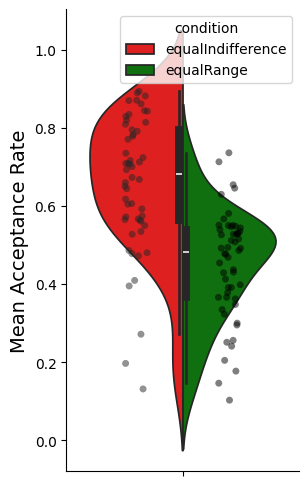

In [121]:
palette = ["red", "green"]
# Create the violin plot
# ax = sns.violinplot(y='accept', data=mean_accept, inner=None)
fig = plt.figure(figsize=(3, 6))
# Add the dots (stripplot)

ax = sns.stripplot(y='mean_accept', data=mean_accept, hue = "condition", color = "black", dodge=True, alpha=0.5, )
sns.violinplot( y='mean_accept', data=mean_accept, hue='condition', palette=palette, ax = ax, split=True)
# Remove duplicate legend entries
handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))  # Keeps first occurrence
ax.legend(unique_labels.values(), unique_labels.keys(), title='condition')

plt.ylabel("Mean Acceptance Rate", fontsize=14)
sns.despine()
plt.show()

In [131]:
mean_accept.query("condition == 'equalRange'")["mean_accept"].std()

np.float64(0.1381902994738799)

In [52]:
conditions = [
    mean_accept['mean_accept'] < 0.4,
    mean_accept['mean_accept'] > 0.6,
    (mean_accept['mean_accept'] >= 0.4) & (mean_accept['mean_accept'] <= 0.60)
]
# Define corresponding choices
choices = ['risk_averse', 'risk_prefered', 'neutral']

# Create new column
mean_accept['risk_profile'] = np.select(conditions, choices, default='unknown')

In [54]:
svs = svs.merge(mean_accept[['sub', 'condition', 'risk_profile']], on=['sub', 'condition'], how='left')

In [44]:
window = 1
svs['subj_value_norm_prev'] = (
    svs.groupby("sub")['subj_value_norm']
       .apply(lambda x: x.rolling(window=window, min_periods=1).mean().shift(1))
       .reset_index(level=0, drop=True)
)

In [45]:
svs = svs.query("trial > 2").reset_index(drop=True)

In [8]:
svs["delta_SV"] = np.abs(svs["subj_value_norm"] - svs["subj_value_norm_prev"])

In [74]:
def compute_group_kde(group):
    kde = gaussian_kde(group['subj_value_norm'])
    group['likelihood'] = kde(group['subj_value_norm'])
    return group

In [75]:
svs = svs.groupby('sub', group_keys=False).apply(compute_group_kde)

/var/folders/xd/6fbjp5ms7ss8c4xxlmz91xkm0000gn/T/ipykernel_77733/1920304134.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  svs = svs.groupby('sub', group_keys=False).apply(compute_group_kde)


In [77]:
pupil_subs = [ 47,  85,  89,  61,  64,  54,  71,  58,  52, 124,  80,  22,   4,
        14,  20,  10,   5,   9,   6,  33,  19,  30,  25,  36,   3,  60,
        87,  45,  75,  79,  49,  63, 115,  94,  40, 123,  70,  98,  82,
        76,  53,  66,  81,  43,  11,  95,  99, 102, 118,  74,  62, 109,
       105,  84,  39]

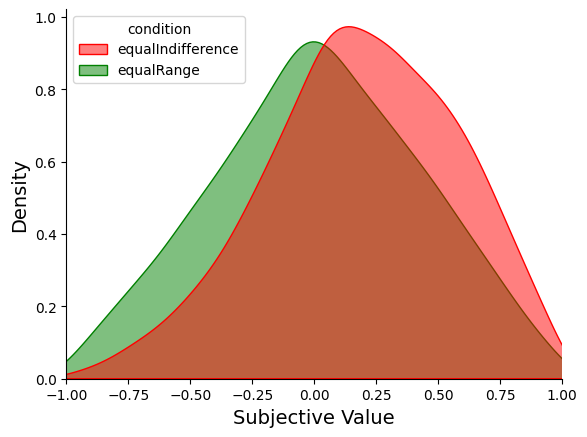

In [99]:
sns.kdeplot(svs.query("sub in @pupil_subs"), x = "subj_value_norm", hue = "condition", palette = palette, fill = True, alpha = 0.5, common_norm = False)
sns.despine()
plt.xlabel("Subjective Value", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xlim(-1, 1)
plt.show()

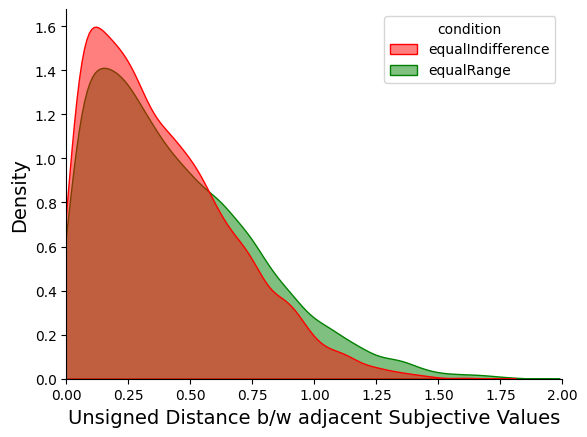

In [120]:
sns.kdeplot(svs.query("sub in @pupil_subs"), x = "delta_SV", hue = "condition", palette = palette, fill = True, alpha = 0.5, common_norm = False)
sns.despine()
plt.xlabel("Unsigned Distance b/w adjacent Subjective Values", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xlim(0, 2)
plt.show()

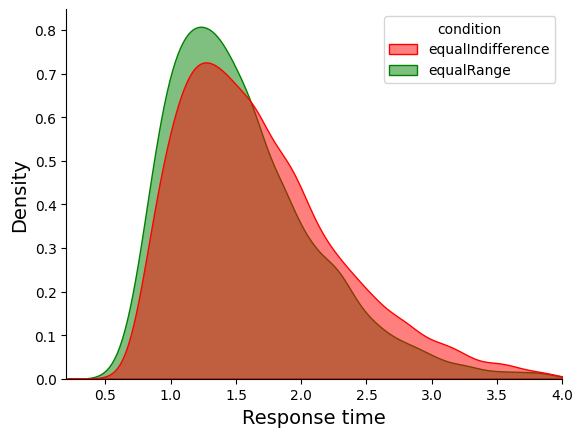

In [101]:
sns.kdeplot(svs.query("sub in @pupil_subs"), x = "RT", hue = "condition", palette = palette, fill = True, alpha = 0.5, common_norm = False)
sns.despine()
plt.xlabel("Response time", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xlim(0.2, 4)
plt.show()

In [118]:
# delete duplicate rows
x = svs.query("sub in @pupil_subs").drop_duplicates(subset=["sub", "condition", "deviation_behavior"])

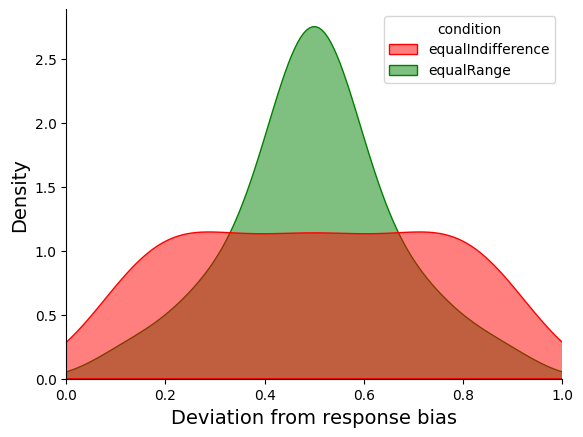

In [119]:
sns.kdeplot(x, x = "deviation_behavior", hue = "condition", palette = palette, fill = True, alpha = 0.5, common_norm = False)
sns.despine()
plt.xlabel("Deviation from response bias", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xlim(0, 1)
plt.show()

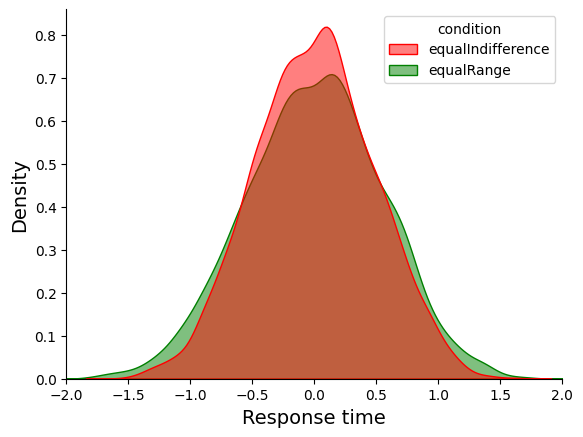

In [30]:
sns.kdeplot(svs.query("sub in @pupil_subs"), x = "signed_delta_SV", hue = "condition", palette = palette, fill = True, alpha = 0.5, common_norm = False)
sns.despine()
plt.xlabel("Response time", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xlim(-2, 2)
plt.show()

/var/folders/xd/6fbjp5ms7ss8c4xxlmz91xkm0000gn/T/ipykernel_77733/1784491169.py:1: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.scatterplot(data=svs.query("sub ==6"), x="likelihood", y="delta_SV", hue = "condition", palette=palette, alpha=0.5)


<Axes: xlabel='likelihood', ylabel='delta_SV'>

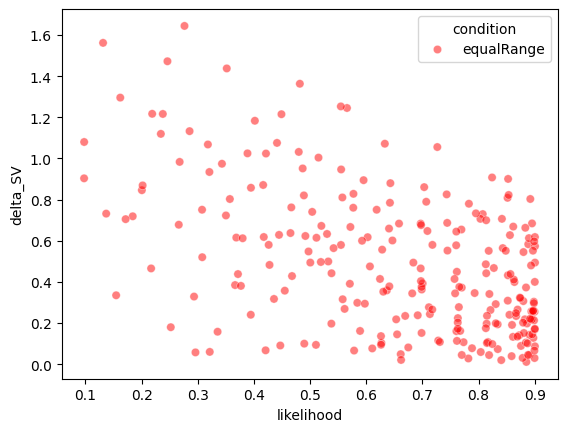

In [90]:
sns.scatterplot(data=svs.query("sub ==6"), x="likelihood", y="delta_SV", hue = "condition", palette=palette, alpha=0.5)

In [81]:
svs.to_csv('behavioral_data_SVs.csv', index=False)

In [12]:
svs

,sub,run,condition,gain,loss,RT,accept,response_int,participant_response,trial,subj_value_norm,subj_value_norm_prev,delta_SV
0,1,1,equalIndifference,34,13,1.873,1,4.0,strongly_accept,3,0.366870,0.316739,0.050131
1,1,1,equalIndifference,10,10,1.457,0,2.0,weakly_reject,4,-0.237712,0.366870,0.604582
2,1,1,equalIndifference,12,19,1.973,0,1.0,strongly_reject,5,-0.597929,-0.237712,0.360217
3,1,1,equalIndifference,20,8,1.767,1,3.0,weakly_accept,6,0.246114,-0.597929,0.844043
4,1,1,equalIndifference,28,9,1.561,1,4.0,strongly_accept,7,0.424512,0.246114,0.178398
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27225,124,4,equalRange,7,14,1.235,0,1.0,strongly_reject,252,-0.493585,-0.154536,0.339049
27226,124,4,equalRange,5,9,1.236,0,1.0,strongly_reject,253,-0.292415,-0.493585,0.201170
27227,124,4,equalRange,5,15,1.030,0,1.0,strongly_reject,254,-0.681378,-0.292415,0.388963
27228,124,4,equalRange,12,18,1.029,0,1.0,strongly_reject,255,-0.446802,-0.681378,0.234576


In [7]:
x = []
for file in os.listdir():
    if file.split("_")[0] == "EV" or file.split("_")[0] == "CPT":
        if file.split("_")[-2] == "subjectFit":
            x.append(pd.read_csv(file))
model_fits = pd.concat(x, ignore_index=True)

In [8]:
dfs_subs = []
for sub in svs["sub"].unique():
    params = model_fits.query(f"sub == {sub} & model == 'CPT_ordinal_history'").reset_index().pivot(index = "sub", columns = "param_names", values = "estimates").reset_index()
    df2 = convert_subjective_SQ(svs.query(f"sub == {sub}").reset_index(), params, column = "SV_CPT_ordinal_prev", model = "CPT_ordinal_history")
    dfs_subs.append(df2)

dfs_subs = pd.concat(dfs_subs, ignore_index=True)

In [11]:
x_cat_sub = dfs_subs.groupby(["sub"])["accept"].mean().reset_index()


In [12]:
conditions = [
    x_cat_sub['accept'] < 0.4,
    x_cat_sub['accept'] > 0.6,
    (x_cat_sub['accept'] >= 0.4) & (x_cat_sub['accept'] <= 0.60)
]
# Define corresponding choices
choices = ['risk_averse', 'risk_prefered', 'neutral']

# Create new column
x_cat_sub['risk_profile'] = np.select(conditions, choices, default='unknown')

In [13]:
# Count how many subjects are in each risk profile
risk_profile_counts = x_cat_sub['risk_profile'].value_counts()
risk_profile_counts

risk_profile
neutral          45
risk_prefered    40
risk_averse      23
Name: count, dtype: int64

In [14]:
# merge this to the dfs_subs 
dfs_subs = dfs_subs.merge(x_cat_sub[['sub', 'risk_profile']], on = "sub", how = "left")
dfs_subs = dfs_subs.merge(mean_accept[['sub', 'mean_accept']], on = "sub", how = "left")

In [15]:
dfs_subs["delta_sq"] = np.abs(dfs_subs["EV_R_CPT"] - dfs_subs["EV_R_SV_CPT_ordinal_prev"])

In [17]:
dfs_subs.to_csv("behavioral_data_SQ_break.csv", index = False)

In [18]:
y = dfs_subs.groupby(["sub", "condition", "risk_profile"])["delta_sq"].mean().reset_index() 

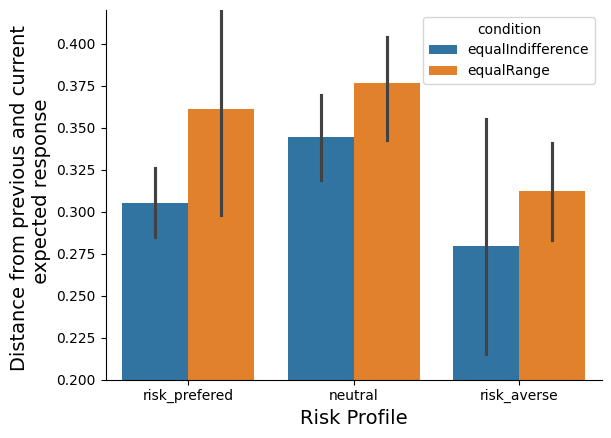

In [19]:
sns.barplot(data=y, x="risk_profile", y="delta_sq", hue="condition")
plt.ylim(0.2, 0.42)
sns.despine()
plt.ylabel("Distance from previous and current \n expected response", fontsize=14)
plt.xlabel("Risk Profile", fontsize=14)
plt.show()

In [81]:
dfs_subs["x_axis_history_bin"] = dfs_subs.groupby(["sub", "condition"])["EV_R_SV_CPT_ordinal_window"].transform(
    lambda x: pd.cut(x, bins = [-0.01, 0.2, 0.4, 0.6, 0.8, 1.01], labels = [0, 0.25, 0.5, 0.75, 1], include_lowest=True)
)

In [82]:
p = dfs_subs.groupby(["sub", "x_axis_history_bin"])['accept'].mean().reset_index()
p = p.merge(x_cat_sub[['sub', 'risk_profile']], on = "sub", how = "left")

/var/folders/xd/6fbjp5ms7ss8c4xxlmz91xkm0000gn/T/ipykernel_47012/1807782786.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  p = dfs_subs.groupby(["sub", "x_axis_history_bin"])['accept'].mean().reset_index()


In [84]:
p = p.merge(mean_accept[['sub', 'mean_accept']], on = "sub", how = "left")

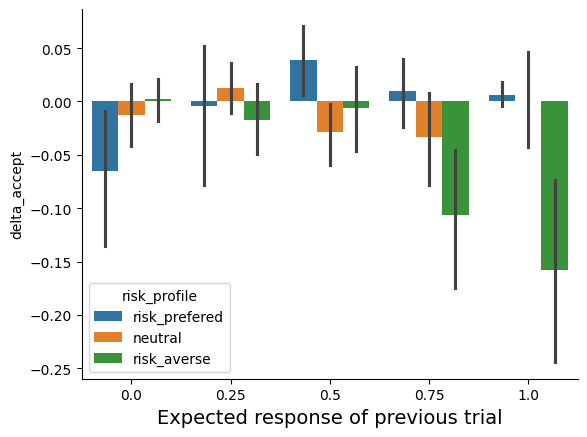

In [90]:
# Plot the binned ordinal window as x axis and y axis the mean risk taking when the subjective valye is greater than 0.5
# We expect that 
ax = sns.barplot(p, x = 'x_axis_history_bin', hue = "risk_profile", y = 'delta_accept')
sns.despine()
plt.xlabel("Expected response of previous trial", fontsize=14)
# plt.ylabel("Mean acceptance of gamble", fontsize=14)
# plt.axhline(y=dfs_subs.query("risk_profile == 'risk_prefered'")["accept"].mean(), color='blue', linestyle='--')
# plt.axhline(y=dfs_subs.query("risk_profile == 'neutral'")["accept"].mean(), color='orange', linestyle='--')
# plt.axhline(y=dfs_subs.query("risk_profile == 'risk_averse'")["accept"].mean(), color='green', linestyle='--')

plt.show()

In [21]:
y = dfs_subs.groupby(["sub", "x_axis_history_bin"])[['accept', 'mean_accept']].mean().reset_index()

/var/folders/xd/6fbjp5ms7ss8c4xxlmz91xkm0000gn/T/ipykernel_47012/529961061.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  y = dfs_subs.groupby(["sub", "x_axis_history_bin"])[['accept', 'mean_accept']].mean().reset_index()


In [33]:
y['delta_accept'] = y['accept'] - y['mean_accept']

In [25]:
# distance_indiff is 0 if x_axis_history_bin is 0.5, its 0.25 if x_axis_history_bin is 0.75 or 0.25, its 0.5 if x_axis_history_bin is 1 or 0
y["distance_indiff"] = np.where(y["x_axis_history_bin"] == 0.5, 0,
    np.where(y["x_axis_history_bin"] == 0.25, 0.25,
             np.where(y["x_axis_history_bin"] == 0.75, 0.25,
                      np.where(y["x_axis_history_bin"] == 1, 0.5, 0.5))))

In [28]:
y = y.merge(x_cat_sub[['sub', 'risk_profile']], on = "sub", how = "left")

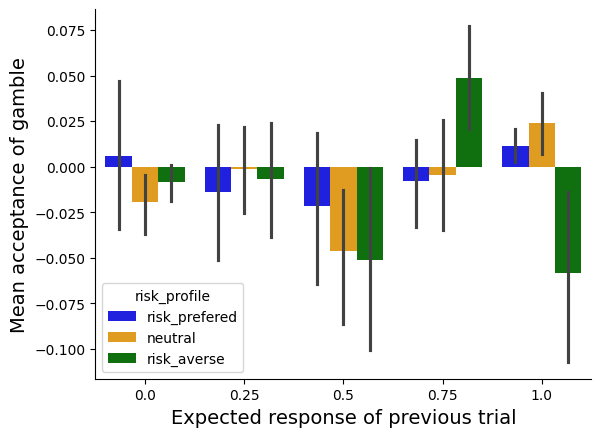

In [36]:
# Plot the binned ordinal window as x axis and y axis the mean risk taking when the subjective valye is greater than 0.5
# We expect that 
ax = sns.barplot(y, x = 'x_axis_history_bin', y = 'delta_accept', hue = "risk_profile", palette = ["blue", "orange", "green"])
sns.despine()
plt.xlabel("Expected response of previous trial", fontsize=14)
plt.ylabel("Mean acceptance of gamble", fontsize=14)

plt.show()

In [20]:
# x-axis is ditance from indifferent response
dfs_subs['distance_from_indifferent'] = np.abs(dfs_subs['EV_R_SV_CPT_ordinal_window'] - 0.5)

In [ ]:
dfs_subs["x_axis_history_bin2"] = dfs_subs.groupby(["sub", "condition"])["distance_from_indifferent"].transform(
    lambda x: pd.cut(x, bins = 4, labels = [0, 0.17, 0.33, 0.5], include_lowest=True)
)

In [212]:
y = dfs_subs.groupby(["sub", "x_axis_history_bin2"])[['accept', 'mean_accept_x']].mean().reset_index()

/var/folders/xd/6fbjp5ms7ss8c4xxlmz91xkm0000gn/T/ipykernel_45101/668567791.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  y = dfs_subs.groupby(["sub", "x_axis_history_bin2"])[['accept', 'mean_accept_x']].mean().reset_index()


In [220]:
y['delta_accept'] = y['accept'] - y['mean_accept_x']

In [222]:
# Plot the binned ordinal window as x axis and y axis the mean risk taking when the subjective valye is greater than 0.5
# We expect that 
sns.lineplot(y, x = 'x_axis_history_bin2', y = 'delta_accept', hue = "risk_profile")
sns.despine()
plt.xlabel("Distance of Expected Response from Indifference \n based on previous SV", fontsize=14)
plt.ylabel("Distance from overall risk-taking", fontsize=14)
# plt.axhline(y=dfs_subs.query("risk_profile == 'risk_prefered'")["accept"].mean(), color='blue', linestyle='--')
# plt.axhline(y=dfs_subs.query("risk_profile == 'neutral'")["accept"].mean(), color='orange', linestyle='--')
# plt.axhline(y=dfs_subs.query("risk_profile == 'risk_averse'")["accept"].mean(), color='green', linestyle='--')

plt.show()

ValueError: Could not interpret value `risk_profile` for `hue`. An entry with this name does not appear in `data`.

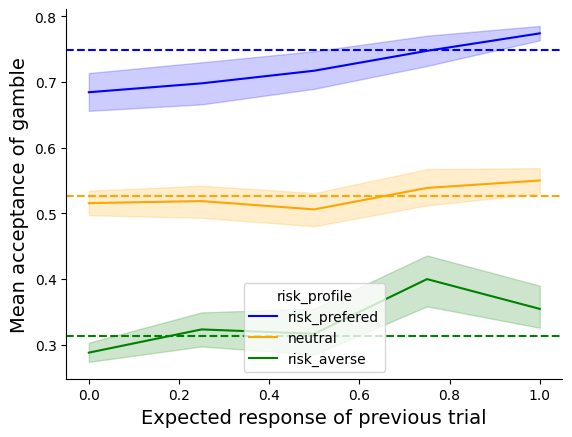

In [218]:
# Plot the binned ordinal window as x axis and y axis the mean risk taking when the subjective valye is greater than 0.5
# We expect that 
ax = sns.lineplot(dfs_subs, x = 'x_axis_history_bin2', y = 'accept', hue = "risk_profile", palette = ["blue", "orange", "green"], markers='o')
sns.despine()
plt.xlabel("Expected response of previous trial", fontsize=14)
plt.ylabel("Mean acceptance of gamble", fontsize=14)
plt.axhline(y=dfs_subs.query("risk_profile == 'risk_prefered'")["accept"].mean(), color='blue', linestyle='--')
plt.axhline(y=dfs_subs.query("risk_profile == 'neutral'")["accept"].mean(), color='orange', linestyle='--')
plt.axhline(y=dfs_subs.query("risk_profile == 'risk_averse'")["accept"].mean(), color='green', linestyle='--')

plt.show()

In [39]:
dfs_subs["sq_break"] = np.abs(dfs_subs["EV_R_CPT"] - dfs_subs["EV_R_SV_CPT_ordinal_window"])

In [40]:
dfs_subs

,index,sub,run,condition,gain,loss,RT,accept,response_int,participant_response,...,EV_R_CPT,SV_CPT_ordinal_window,EV_R_SV_CPT_ordinal_window,sq_break,aligned_history,real_history_aligned_not,history_beats_real,x_axis_history,x_axis_history_bin,risk_profile
0,0,1,1,equalIndifference,16,6,2.080,1,3.0,weakly_accept,...,8.207985e-01,3.495316,0.842325,0.021526,True,True,True,0.342325,0.50,risk_prefered
1,1,1,1,equalIndifference,16,5,1.871,1,3.0,weakly_accept,...,9.507387e-01,3.243455,0.801065,0.149674,True,True,True,0.301065,0.50,risk_prefered
2,2,1,1,equalIndifference,10,15,2.080,0,1.0,strongly_reject,...,1.802305e-01,3.763001,0.885143,0.704913,False,True,False,0.385143,0.75,risk_prefered
3,3,1,1,equalIndifference,16,17,2.288,0,2.0,weakly_reject,...,3.959970e-01,3.970217,0.914835,0.518838,False,True,False,0.414835,0.75,risk_prefered
4,4,1,1,equalIndifference,20,9,2.807,1,3.0,weakly_accept,...,7.112152e-01,3.432706,0.831994,0.120779,True,True,True,0.331994,0.50,risk_prefered
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26476,26476,124,4,equalRange,7,14,1.235,0,1.0,strongly_reject,...,5.288040e-05,-3.477950,0.281323,0.281271,True,False,False,0.218677,0.50,risk_averse
26477,26477,124,4,equalRange,5,9,1.236,0,1.0,strongly_reject,...,7.802900e-02,-3.593128,0.272027,0.193998,True,False,False,0.227973,0.50,risk_averse
26478,26478,124,4,equalRange,5,15,1.030,0,1.0,strongly_reject,...,4.512568e-11,-3.907102,0.242011,0.242011,True,False,False,0.257989,0.25,risk_averse
26479,26479,124,4,equalRange,12,18,1.029,0,1.0,strongly_reject,...,5.373929e-04,-5.866108,0.034388,0.033851,True,False,False,0.465612,0.00,risk_averse


In [ ]:
dfs_subs["sq_break2"] = dfs_subs["EV_R_SV_CPT_ordinal_window"]

In [65]:
dfs_subs["history_window_bin"] = dfs_subs.groupby(["sub", "condition"])["EV_R_SV_CPT_ordinal_window"].transform(
    lambda x: pd.cut(x, bins = 4, labels = [1, 2, 3, 4], include_lowest=True)
)

/var/folders/xd/6fbjp5ms7ss8c4xxlmz91xkm0000gn/T/ipykernel_36022/3512864347.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="history_window_bin", y="accept", data=dfs_subs, hue="condition", ci=None)


<Axes: xlabel='history_window_bin', ylabel='accept'>

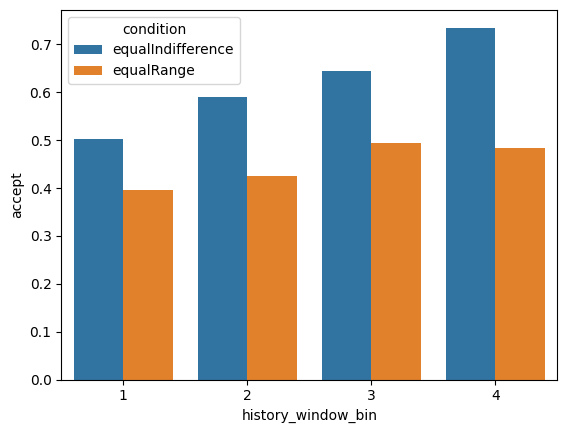

In [66]:
sns.barplot(x="history_window_bin", y="accept", data=dfs_subs, hue="condition", ci=None)

<Axes: xlabel='trial', ylabel='sq_break'>

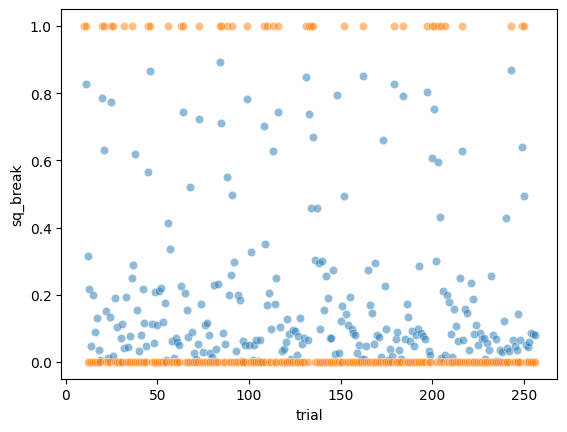

In [57]:
sns.scatterplot(data=dfs_subs.query("sub == 8"), x="trial", y="sq_break", alpha=0.5)
sns.scatterplot(data = dfs_subs.query("sub == 8"), x="trial", y="accept", alpha=0.5)

In [13]:
df = svs.query("sub == 1")

In [18]:
df['prev_mean_v'] = df['SV_EV_ordinal_history'].rolling(window=7, min_periods=1).mean().shift(1)


/var/folders/xd/6fbjp5ms7ss8c4xxlmz91xkm0000gn/T/ipykernel_27007/1545016141.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev_mean_v'] = df['SV_EV_ordinal_history'].rolling(window=7, min_periods=1).mean().shift(1)


In [20]:
df['diff'] =df['SV_EV_ordinal_history']  - df['prev_mean_v']

/var/folders/xd/6fbjp5ms7ss8c4xxlmz91xkm0000gn/T/ipykernel_27007/1160346209.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff'] =df['SV_EV_ordinal_history']  - df['prev_mean_v']


<Axes: xlabel='trial', ylabel='diff'>

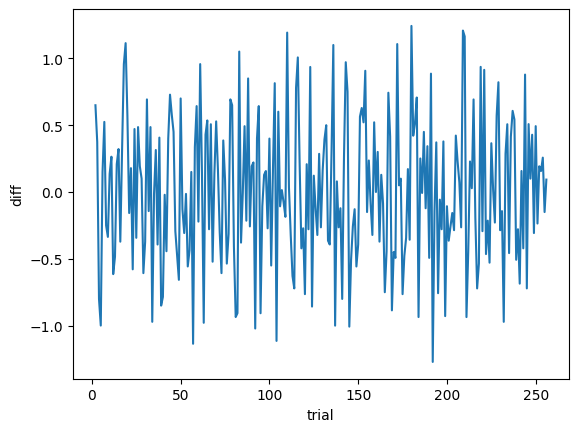

In [21]:
sns.lineplot(df, x = 'trial', y = 'diff')

In [12]:
np.mean(svs.query("sub == 1")['accept'] == 0)

np.float64(0.13725490196078433)